In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta

In [2]:
merged_dataset= pd.read_csv('/content/merged_fire_climate_dataset.csv')
merged_dataset.head()

,Date,Temperature_Max,Relative_Humidity,Precipitation,Wind_Speed,Surface Soil Wetness,Root Zone Soil Wetness,Coordinate_Group_,Local_Time_Min,Max_Brightness,Mean_Brightness,Max_Confidence,Mean_Confidence,FRP,Day_Night,Time_Period,Total_Fire_Incidents,FRP_Bin,Fire_Recorded
0,1/1/15,9.37,43.38,0.0,2.54,0.56,0.59,No Fire,No Fire,0.0,0.0,0,0.0,0.0,No Fire,No Fire,0,No Fire,0
1,1/2/15,9.87,49.00,0.0,1.73,0.56,0.59,No Fire,No Fire,0.0,0.0,0,0.0,0.0,No Fire,No Fire,0,No Fire,0
2,1/3/15,11.43,53.00,0.0,1.60,0.56,0.59,South-East,10:46:00,328.5,328.5,86,86.0,37.4,D,Morning,1,20-40,1
3,1/4/15,14.44,55.62,0.0,1.70,0.56,0.59,No Fire,No Fire,0.0,0.0,0,0.0,0.0,No Fire,No Fire,0,No Fire,0
4,1/5/15,19.90,53.69,0.0,2.07,0.56,0.59,No Fire,No Fire,0.0,0.0,0,0.0,0.0,No Fire,No Fire,0,No Fire,0


### Introducing a new feature called 'Season' to analyze seaonsal impact on wildfires

In [ ]:
def classify_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Assuming 'Date' column is already in datetime format. If not, convert it first.
if not pd.api.types.is_datetime64_any_dtype(merged_dataset['Date']):
    merged_dataset['Date'] = pd.to_datetime(merged_dataset['Date'])

merged_dataset['Month'] = merged_dataset['Date'].dt.month
merged_dataset['Season'] = merged_dataset['Month'].apply(classify_season)

In [ ]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6377 entries, 0 to 6376
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    6377 non-null   datetime64[ns]
 1   Temperature_Max         6377 non-null   float64       
 2   Relative_Humidity       6377 non-null   float64       
 3   Precipitation           6377 non-null   float64       
 4   Wind_Speed              6377 non-null   float64       
 5   Surface Soil Wetness    6377 non-null   float64       
 6   Root Zone Soil Wetness  6377 non-null   float64       
 7   Coordinate_Group_       6377 non-null   object        
 8   Local_Time_Min          6377 non-null   object        
 9   Max_Brightness          6377 non-null   float64       
 10  Mean_Brightness         6377 non-null   float64       
 11  Max_Confidence          6377 non-null   int64         
 12  Mean_Confidence         6377 non-null   float64 

In [ ]:
merged_dataset.head()

,Date,Temperature_Max,Relative_Humidity,Precipitation,Wind_Speed,Surface Soil Wetness,Root Zone Soil Wetness,Coordinate_Group_,Local_Time_Min,Max_Brightness,...,Max_Confidence,Mean_Confidence,FRP,Day_Night,Time_Period,Total_Fire_Incidents,FRP_Bin,Fire_Recorded,Month,Season
0,2015-01-01,9.37,43.38,0.0,2.54,0.56,0.59,No Fire,No Fire,0.0,...,0,0.0,0.0,No Fire,No Fire,0,No Fire,0,1,Winter
1,2015-01-02,9.87,49.00,0.0,1.73,0.56,0.59,No Fire,No Fire,0.0,...,0,0.0,0.0,No Fire,No Fire,0,No Fire,0,1,Winter
2,2015-01-03,11.43,53.00,0.0,1.60,0.56,0.59,South-East,10:46:00,328.5,...,86,86.0,37.4,D,Morning,1,20-40,1,1,Winter
3,2015-01-04,14.44,55.62,0.0,1.70,0.56,0.59,No Fire,No Fire,0.0,...,0,0.0,0.0,No Fire,No Fire,0,No Fire,0,1,Winter
4,2015-01-05,19.90,53.69,0.0,2.07,0.56,0.59,No Fire,No Fire,0.0,...,0,0.0,0.0,No Fire,No Fire,0,No Fire,0,1,Winter


## Predicting intensity and scale of a wildfire

### Multiple target variables: Using a regressor and random forest classifier to handle numerical and categorical variables, respectively

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.model_selection import train_test_split

# Filter out "No Fire" records
dataset = merged_dataset[merged_dataset['Fire_Recorded'] == 1].copy()

# Convert categorical features to dummy variables
dataset = pd.get_dummies(dataset, columns=['Coordinate_Group_', 'Day_Night', 'Time_Period', 'Season'], drop_first=True)

# Separate features and targets
X = dataset[['Temperature_Max', 'Relative_Humidity', 'Precipitation', 'Wind_Speed',
             'Surface Soil Wetness', 'Root Zone Soil Wetness',
             'Coordinate_Group__Central-East', 'Coordinate_Group__North-Central',
             'Coordinate_Group__North-East', 'Coordinate_Group__North-West',
             'Coordinate_Group__South-Central', 'Coordinate_Group__South-East']]

# Split categorical and numeric targets
y_categorical = dataset[['Coordinate_Group__North-Central', 'Coordinate_Group__North-East', 'Coordinate_Group__North-West',
             'Coordinate_Group__South-Central', 'Coordinate_Group__South-East',
                         'Time_Period_Early Morning', 'Time_Period_Morning',
                         'Time_Period_Night']]
y_numeric = dataset[['Total_Fire_Incidents', 'FRP']]  # Numeric target


In [ ]:
# Ensure all categorical targets are converted to strings
y_categorical = y_categorical.astype(str)

# Split data into training and testing sets
X_train, X_test, y_train_cat, y_test_cat = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
_, _, y_train_num, y_test_num = train_test_split(X, y_numeric, test_size=0.3, random_state=42)

# Train classifiers for categorical targets
base_model = RandomForestClassifier(random_state=42)
multioutput_classifier = MultiOutputClassifier(base_model)
multioutput_classifier.fit(X_train, y_train_cat)

# Train regression model for numeric targets
regressor = LinearRegression()
regressor.fit(X_train, y_train_num)

# Predictions for categorical targets
y_pred_cat = multioutput_classifier.predict(X_test)

# Predictions for numeric targets
y_pred_num = regressor.predict(X_test)

# Evaluate categorical predictions
print("Classification Report for Categorical Targets:")
for i, col in enumerate(y_categorical.columns):
    print(f"\nTarget: {col}")
    print(classification_report(y_test_cat.iloc[:, i], y_pred_cat[:, i]))

# Evaluate numeric predictions
print("\nRegression Report for Total_Fire_Incidents:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_num, y_pred_num):.4f}")


Classification Report for Categorical Targets:

Target: Coordinate_Group__North-Central
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1200
        True       1.00      1.00      1.00       426

    accuracy                           1.00      1626
   macro avg       1.00      1.00      1.00      1626
weighted avg       1.00      1.00      1.00      1626


Target: Coordinate_Group__North-East
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1500
        True       1.00      1.00      1.00       126

    accuracy                           1.00      1626
   macro avg       1.00      1.00      1.00      1626
weighted avg       1.00      1.00      1.00      1626


Target: Coordinate_Group__North-West
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1487
        True       1.00      1.00      1.00       139

    accuracy      

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Filter out "No Fire" records
dataset = merged_dataset[merged_dataset['Fire_Recorded'] == 1].copy()

# Convert categorical features to dummy variables
dataset = pd.get_dummies(dataset, columns=['Coordinate_Group_', 'Day_Night', 'Time_Period', 'Season'], drop_first=True)

# Separate features and targets
X = dataset[['Temperature_Max', 'Relative_Humidity', 'Precipitation', 'Wind_Speed',
             'Surface Soil Wetness', 'Root Zone Soil Wetness',
             'Coordinate_Group__Central-East', 'Coordinate_Group__North-Central',
             'Coordinate_Group__North-East', 'Coordinate_Group__North-West',
             'Coordinate_Group__South-Central', 'Coordinate_Group__South-East']]

# Split categorical and numeric targets
y_categorical = dataset[['Time_Period_Early Morning',
                         'Time_Period_Morning', 'Time_Period_Night']]
y_numeric = dataset[['Total_Fire_Incidents', 'FRP']]  # Numeric target

# Encode categorical targets as integers
encoders = {}
for col in y_categorical.columns:
    encoder = LabelEncoder()
    y_categorical[col] = encoder.fit_transform(y_categorical[col])
    encoders[col] = encoder  # Save the encoder for later inverse transformation

# Split data into training and testing sets
X_train, X_test, y_train_cat, y_test_cat = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
_, _, y_train_num, y_test_num = train_test_split(X, y_numeric, test_size=0.3, random_state=42)

# Combine X_train and y_train_cat for oversampling
train_combined = X_train.copy()
for col in y_train_cat.columns:
    train_combined[col] = y_train_cat[col]

# Apply RandomOverSampler to combined dataset
ros = RandomOverSampler(random_state=42)
train_combined_res, _ = ros.fit_resample(train_combined, y_train_cat.iloc[:, 0])

# Split back into X_train_res and y_train_res
X_train_res = train_combined_res[X_train.columns]
y_train_res = train_combined_res[y_train_cat.columns]

# Train classifiers for categorical targets
base_model = RandomForestClassifier(random_state=42)
multioutput_classifier = MultiOutputClassifier(base_model)
multioutput_classifier.fit(X_train_res, y_train_res)

# Scale features for regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train regression model for numeric targets
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train_num)

# Predictions for categorical targets
y_pred_cat = multioutput_classifier.predict(X_test)

# Predictions for numeric targets
y_pred_num = regressor.predict(X_test_scaled)

# Evaluate categorical predictions
print("Classification Report for Categorical Targets:")
for i, col in enumerate(y_categorical.columns):
    print(f"\nTarget: {col}")
    print(classification_report(y_test_cat.iloc[:, i], y_pred_cat[:, i]))

# Evaluate numeric predictions
print("\nRegression Report for Total_Fire_Incidents and FRP:")
for i, col in enumerate(y_numeric.columns):
    print(f"Target: {col}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test_num.iloc[:, i], y_pred_num[:, i]):.4f}")


Classification Report for Categorical Targets:

Target: Time_Period_Early Morning
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1490
           1       0.14      0.04      0.07       136

    accuracy                           0.90      1626
   macro avg       0.53      0.51      0.51      1626
weighted avg       0.85      0.90      0.87      1626


Target: Time_Period_Morning
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1233
           1       0.63      0.19      0.29       393

    accuracy                           0.78      1626
   macro avg       0.71      0.58      0.58      1626
weighted avg       0.75      0.78      0.73      1626


Target: Time_Period_Night
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1366
           1       0.36      0.13      0.20       260

    accuracy                           0.82 

In [ ]:
dataset.columns

Index(['Date', 'Temperature_Max', 'Relative_Humidity', 'Precipitation',
       'Wind_Speed', 'Surface Soil Wetness', 'Root Zone Soil Wetness',
       'Local_Time_Min', 'Max_Brightness', 'Mean_Brightness', 'Max_Confidence',
       'Mean_Confidence', 'FRP', 'Total_Fire_Incidents', 'FRP_Bin',
       'Fire_Recorded', 'Month', 'Coordinate_Group__Central-East',
       'Coordinate_Group__North-Central', 'Coordinate_Group__North-East',
       'Coordinate_Group__North-West', 'Coordinate_Group__South-Central',
       'Coordinate_Group__South-East', 'Day_Night_N',
       'Time_Period_Early Morning', 'Time_Period_Morning', 'Time_Period_Night',
       'Season_Spring', 'Season_Summer', 'Season_Winter'],
      dtype='object')

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Filter out "No Fire" records
dataset = merged_dataset[merged_dataset['Fire_Recorded'] == 1].copy()

# Convert categorical features to dummy variables
dataset = pd.get_dummies(dataset, columns=['Coordinate_Group_', 'Day_Night', 'Time_Period'], drop_first=True)

# Separate features and targets
X = dataset[['Temperature_Max', 'Relative_Humidity', 'Precipitation', 'Wind_Speed',
             'Surface Soil Wetness', 'Root Zone Soil Wetness',
             'Coordinate_Group__Central-East', 'Coordinate_Group__North-Central',
             'Coordinate_Group__North-East', 'Coordinate_Group__North-West',
             'Coordinate_Group__South-Central', 'Coordinate_Group__South-East']]

# Split categorical and numeric targets
y_categorical = dataset[['Day_Night_N']]
y_numeric = dataset[['Total_Fire_Incidents', 'FRP', 'Max_Brightness', 'Mean_Brightness']]  # Numeric target

# Encode categorical targets as integers
encoders = {}
for col in y_categorical.columns:
    encoder = LabelEncoder()
    y_categorical[col] = encoder.fit_transform(y_categorical[col])
    encoders[col] = encoder  # Save the encoder for later inverse transformation

# Split data into training and testing sets
X_train, X_test, y_train_cat, y_test_cat = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
_, _, y_train_num, y_test_num = train_test_split(X, y_numeric, test_size=0.3, random_state=42)

# Combine X_train and y_train_cat for oversampling
train_combined = X_train.copy()
for col in y_train_cat.columns:
    train_combined[col] = y_train_cat[col]

# Apply RandomOverSampler to combined dataset
ros = RandomOverSampler(random_state=42)
train_combined_res, _ = ros.fit_resample(train_combined, y_train_cat.iloc[:, 0])

# Split back into X_train_res and y_train_res
X_train_res = train_combined_res[X_train.columns]
y_train_res = train_combined_res[y_train_cat.columns]

# Train classifiers for categorical targets
base_model = RandomForestClassifier(random_state=42)
multioutput_classifier = MultiOutputClassifier(base_model)
multioutput_classifier.fit(X_train_res, y_train_res)

# Scale features for regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train regression model for numeric targets
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train_num)

# Predictions for categorical targets
y_pred_cat = multioutput_classifier.predict(X_test)

# Predictions for numeric targets
y_pred_num = regressor.predict(X_test_scaled)

# Evaluate categorical predictions
print("Classification Report for Categorical Targets:")
for i, col in enumerate(y_categorical.columns):
    print(f"\nTarget: {col}")
    print(classification_report(y_test_cat.iloc[:, i], y_pred_cat[:, i]))

# Evaluate numeric predictions
print("\nRegression Report for Total_Fire_Incidents and FRP:")
for i, col in enumerate(y_numeric.columns):
    print(f"Target: {col}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test_num.iloc[:, i], y_pred_num[:, i]):.4f}")


Classification Report for Categorical Targets:

Target: Day_Night_N
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1216
           1       0.47      0.50      0.48       410

    accuracy                           0.73      1626
   macro avg       0.65      0.65      0.65      1626
weighted avg       0.74      0.73      0.73      1626


Regression Report for Total_Fire_Incidents and FRP:
Target: Total_Fire_Incidents
Mean Absolute Error: 22.5114
Target: FRP
Mean Absolute Error: 449.5912
Target: Max_Brightness
Mean Absolute Error: 30.0125
Target: Mean_Brightness
Mean Absolute Error: 10.7215


In [ ]:

from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Filter out "No Fire" records
dataset = merged_dataset[merged_dataset['Fire_Recorded'] == 1].copy()

# Convert categorical features to dummy variables
dataset = pd.get_dummies(dataset, columns=['Coordinate_Group_', 'Day_Night', 'Time_Period', 'Season'], drop_first=True)

# Separate features and targets
X = dataset[['Temperature_Max', 'Relative_Humidity', 'Precipitation', 'Wind_Speed',
             'Surface Soil Wetness', 'Root Zone Soil Wetness',
             'Coordinate_Group__Central-East', 'Coordinate_Group__North-Central',
             'Coordinate_Group__North-East', 'Coordinate_Group__North-West',
             'Coordinate_Group__South-Central', 'Coordinate_Group__South-East', 'Season_Spring', 'Season_Summer', 'Season_Winter']]

# Split categorical and numeric targets
y_categorical = dataset[['Day_Night_N']]
y_numeric = dataset[['Total_Fire_Incidents', 'FRP', 'Max_Brightness', 'Mean_Brightness']]  # Numeric target

# Encode categorical targets as integers
encoders = {}
for col in y_categorical.columns:
    encoder = LabelEncoder()
    y_categorical[col] = encoder.fit_transform(y_categorical[col])
    encoders[col] = encoder  # Save the encoder for later inverse transformation

# Split data into training and testing sets
X_train, X_test, y_train_cat, y_test_cat = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
_, _, y_train_num, y_test_num = train_test_split(X, y_numeric, test_size=0.3, random_state=42)

# Combine X_train and y_train_cat for oversampling
train_combined = X_train.copy()
for col in y_train_cat.columns:
    train_combined[col] = y_train_cat[col]

# Apply RandomOverSampler to combined dataset
ros = RandomOverSampler(random_state=42)
train_combined_res, _ = ros.fit_resample(train_combined, y_train_cat.iloc[:, 0])

# Split back into X_train_res and y_train_res
X_train_res = train_combined_res[X_train.columns]
y_train_res = train_combined_res[y_train_cat.columns]

# Train classifiers for categorical targets
base_model = RandomForestClassifier(random_state=42)
multioutput_classifier = MultiOutputClassifier(base_model)
multioutput_classifier.fit(X_train_res, y_train_res)

# Scale features for regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train regression model for numeric targets
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train_num)

# Predictions for categorical targets
y_pred_cat = multioutput_classifier.predict(X_test)

# Predictions for numeric targets
y_pred_num = regressor.predict(X_test_scaled)

# Evaluate categorical predictions
print("Classification Report for Categorical Targets:")
for i, col in enumerate(y_categorical.columns):
    print(f"\nTarget: {col}")
    print(classification_report(y_test_cat.iloc[:, i], y_pred_cat[:, i]))

# Evaluate numeric predictions
print("\nRegression Report for Total_Fire_Incidents and FRP:")
for i, col in enumerate(y_numeric.columns):
    print(f"Target: {col}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test_num.iloc[:, i], y_pred_num[:, i]):.4f}")


Classification Report for Categorical Targets:

Target: Day_Night_N
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1216
           1       0.49      0.53      0.51       410

    accuracy                           0.74      1626
   macro avg       0.67      0.67      0.67      1626
weighted avg       0.75      0.74      0.75      1626


Regression Report for Total_Fire_Incidents and FRP:
Target: Total_Fire_Incidents
Mean Absolute Error: 22.5213
Target: FRP
Mean Absolute Error: 451.4036
Target: Max_Brightness
Mean Absolute Error: 30.0591
Target: Mean_Brightness
Mean Absolute Error: 10.7116


## Best Model: Includes the earliest Local Time at which a wildfire was recorded

In [ ]:
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Filter out "No Fire" records
dataset = merged_dataset[merged_dataset['Fire_Recorded'] == 1].copy()

# Convert categorical features to dummy variables
dataset = pd.get_dummies(dataset, columns=['Coordinate_Group_', 'Day_Night', 'Time_Period', 'Season'], drop_first=True)

# Preprocessing for time column
if 'Local_Time_Min' in dataset.columns:
    dataset['Local_Time_Min'] = pd.to_datetime(dataset['Local_Time_Min'], errors='coerce').dt.hour  # Convert to hour of day

# Separate features and targets
X = dataset[['Temperature_Max', 'Relative_Humidity', 'Precipitation', 'Wind_Speed',
             'Surface Soil Wetness', 'Root Zone Soil Wetness',
             'Coordinate_Group__Central-East', 'Coordinate_Group__North-Central',
             'Coordinate_Group__North-East', 'Coordinate_Group__North-West',
             'Coordinate_Group__South-Central', 'Coordinate_Group__South-East',
             'Season_Spring', 'Season_Summer', 'Season_Winter', 'Local_Time_Min']] #New variable 'Local_Time_Min' added

# Split categorical and numeric targets
y_categorical = dataset[['Day_Night_N']]
y_numeric = dataset[['Total_Fire_Incidents', 'FRP', 'Max_Brightness', 'Mean_Brightness']]  # Numeric target

# Encode categorical targets as integers
encoders = {}
for col in y_categorical.columns:
    encoder = LabelEncoder()
    y_categorical[col] = encoder.fit_transform(y_categorical[col])
    encoders[col] = encoder  # Save the encoder for later inverse transformation

# Split data into training and testing sets
X_train, X_test, y_train_cat, y_test_cat = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
_, _, y_train_num, y_test_num = train_test_split(X, y_numeric, test_size=0.3, random_state=42)

# Combine X_train and y_train_cat for oversampling
train_combined = X_train.copy()
for col in y_train_cat.columns:
    train_combined[col] = y_train_cat[col]

# Apply RandomOverSampler to combined dataset
ros = RandomOverSampler(random_state=42)
train_combined_res, _ = ros.fit_resample(train_combined, y_train_cat.iloc[:, 0])

# Split back into X_train_res and y_train_res
X_train_res = train_combined_res[X_train.columns]
y_train_res = train_combined_res[y_train_cat.columns]

# Train classifiers for categorical targets
base_model = RandomForestClassifier(random_state=42)
multioutput_classifier = MultiOutputClassifier(base_model)
multioutput_classifier.fit(X_train_res, y_train_res)

# Select only numeric columns for scaling
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

# Scale Numeric Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# Train regression model for numeric targets
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train_num)

# Predictions for categorical targets
y_pred_cat = multioutput_classifier.predict(X_test)

# Predictions for numeric targets
y_pred_num = regressor.predict(X_test_scaled)

# Evaluate categorical predictions
print("Classification Report for Categorical Targets:")
for i, col in enumerate(y_categorical.columns):
    print(f"\nTarget: {col}")
    print(classification_report(y_test_cat.iloc[:, i], y_pred_cat[:, i]))

# Evaluate numeric predictions
print("\nRegression Report for Numeric Targets:")
for i, col in enumerate(y_numeric.columns):
    print(f"Target: {col}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test_num.iloc[:, i], y_pred_num[:, i]):.4f}")


Classification Report for Categorical Targets:

Target: Day_Night_N
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1216
           1       0.70      0.75      0.72       410

    accuracy                           0.85      1626
   macro avg       0.81      0.82      0.81      1626
weighted avg       0.86      0.85      0.86      1626


Regression Report for Numeric Targets:
Target: Total_Fire_Incidents
Mean Absolute Error: 20.5907
Target: FRP
Mean Absolute Error: 433.1063
Target: Max_Brightness
Mean Absolute Error: 27.4268
Target: Mean_Brightness
Mean Absolute Error: 11.0785


The below code Combines X_train and y_train_cat into a single dataset for oversampling.

After oversampling, numeric targets (y_train_num) are aligned with the resampled data by replicating rows to match the oversampled feature size.

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler

# Filter out "No Fire" records
dataset = merged_dataset[merged_dataset['Fire_Recorded'] == 1].copy()

# Convert categorical features to dummy variables
dataset = pd.get_dummies(dataset, columns=['Coordinate_Group_', 'Day_Night', 'Time_Period', 'Season'], drop_first=True)

# Separate features and targets
X = dataset[['Temperature_Max', 'Relative_Humidity', 'Precipitation', 'Wind_Speed',
             'Surface Soil Wetness', 'Root Zone Soil Wetness',
             'Coordinate_Group__Central-East', 'Coordinate_Group__North-Central',
             'Coordinate_Group__North-East', 'Coordinate_Group__North-West',
             'Coordinate_Group__South-Central', 'Coordinate_Group__South-East',
             'Season_Spring', 'Season_Summer', 'Season_Winter']]

# Split categorical and numeric targets
y_categorical = dataset[['Day_Night_N']]
y_numeric = dataset[['Total_Fire_Incidents', 'FRP', 'Max_Brightness', 'Mean_Brightness']]  # Numeric target

# Encode categorical targets as integers
encoders = {}
for col in y_categorical.columns:
    encoder = LabelEncoder()
    y_categorical[col] = encoder.fit_transform(y_categorical[col])
    encoders[col] = encoder  # Save the encoder for later inverse transformation

# Split data into training and testing sets
X_train, X_test, y_train_cat, y_test_cat = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
_, _, y_train_num, y_test_num = train_test_split(X, y_numeric, test_size=0.3, random_state=42)

# Combine X_train and y_train_cat for oversampling
train_combined = pd.concat([X_train.reset_index(drop=True), y_train_cat.reset_index(drop=True)], axis=1)

# Apply RandomOverSampler to combined dataset
ros = RandomOverSampler(random_state=42)
train_combined_res, y_train_cat_res = ros.fit_resample(train_combined, y_train_cat)

# Split back the resampled features
X_train_res = train_combined_res[X_train.columns]

# Align numeric targets with resampled data
y_train_num_res = pd.concat([y_train_num] * (len(X_train_res) // len(y_train_num) + 1), ignore_index=True).iloc[:len(X_train_res)]

# Debugging Output: Check alignment
print(f"Shape of X_train_res: {X_train_res.shape}")
print(f"Shape of y_train_cat_res: {y_train_cat_res.shape}")
print(f"Shape of y_train_num_res: {y_train_num_res.shape}")

# Split resampled data into train and validation sets
X_train_full, X_valid, y_train_cat_full, y_valid_cat, y_train_num_full, y_valid_num = train_test_split(
    X_train_res, y_train_cat_res, y_train_num_res, test_size=0.2, random_state=42
)

# Train classifiers for categorical targets
base_model = RandomForestClassifier(random_state=42)
multioutput_classifier = MultiOutputClassifier(base_model)
multioutput_classifier.fit(X_train_full, y_train_cat_full)

# Scale features for regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_valid_scaled = scaler.transform(X_valid)

# Train regression model for numeric targets
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train_num_full)

# Predictions for categorical targets
y_pred_cat = multioutput_classifier.predict(X_valid)

# Predictions for numeric targets
y_pred_num = regressor.predict(X_valid_scaled)

# Evaluate categorical predictions
print("Classification Report for Categorical Targets:")
for i, col in enumerate(y_categorical.columns):
    print(f"\nTarget: {col}")
    print(classification_report(y_valid_cat.iloc[:, i], y_pred_cat[:, i]))

# Evaluate numeric predictions
print("\nRegression Report for Numeric Targets:")
for i, col in enumerate(y_numeric.columns):
    print(f"Target: {col}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_valid_num.iloc[:, i], y_pred_num[:, i]):.4f}")


Shape of X_train_res: (5410, 15)
Shape of y_train_cat_res: (5410, 1)
Shape of y_train_num_res: (5410, 4)
Classification Report for Categorical Targets:

Target: Day_Night_N
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       549
           1       0.80      0.90      0.85       533

    accuracy                           0.84      1082
   macro avg       0.85      0.85      0.84      1082
weighted avg       0.85      0.84      0.84      1082


Regression Report for Numeric Targets:
Target: Total_Fire_Incidents
Mean Absolute Error: 22.9085
Target: FRP
Mean Absolute Error: 432.2399
Target: Max_Brightness
Mean Absolute Error: 32.3599
Target: Mean_Brightness
Mean Absolute Error: 11.4251


### SHAP:

The SHAP interaction plot highlights the interaction effects between the two features, Temperature_Max and Relative_Humidity, on the model's output.

Analysis:

**Temperature_Max**:
The interaction plot indicates that Temperature_Max has both positive and negative impacts on the predictions, depending on its value.
High Temperature_Max values (red points) seem to increase the SHAP interaction value, indicating that higher temperatures likely increase the model's prediction of the target (e.g., fire-related outcomes).
Conversely, lower Temperature_Max values (blue points) generally reduce the interaction value.

**Relative_Humidity:**
For Relative_Humidity, the impact is inversely related to Temperature_Max:
High humidity values (red points) are associated with lower SHAP interaction values, suggesting that increased humidity likely reduces the likelihood of the predicted outcome.
Low humidity values (blue points) contribute positively to the SHAP interaction value, aligning with the potential for drier conditions to increase fire activity.

**Interaction:**
**The cross-diagonal structure shows how the two features interact:**
High Temperature_Max combined with low Relative_Humidity (top-left quadrant) leads to a strong positive interaction, indicating higher risk.
Conversely, low Temperature_Max combined with high Relative_Humidity (bottom-right quadrant) results in a negative interaction, reducing the likelihood of the target.
Symmetry:
The symmetry in the plot suggests that both features contribute consistently across different value ranges, but the intensity varies based on their combined levels.

**Future Scope: Insights for Model Refinement:->**
Temperature_Max and Relative_Humidity are key drivers for the model's prediction, particularly in their interaction.
Future improvements could explore thresholds or nonlinear transformations for these features to better capture their behavior.
Analyzing the residuals after accounting for these features might uncover additional patterns for further refinement.

Analyzing Feature Importance with SHAP for Classification...

SHAP Analysis for Target: Day_Night_N


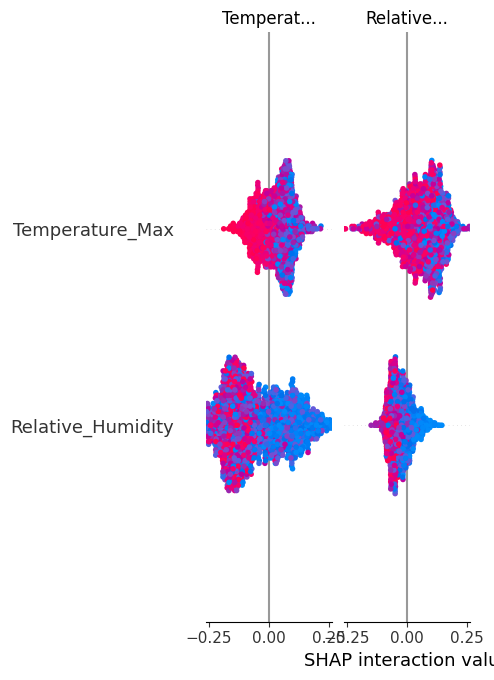

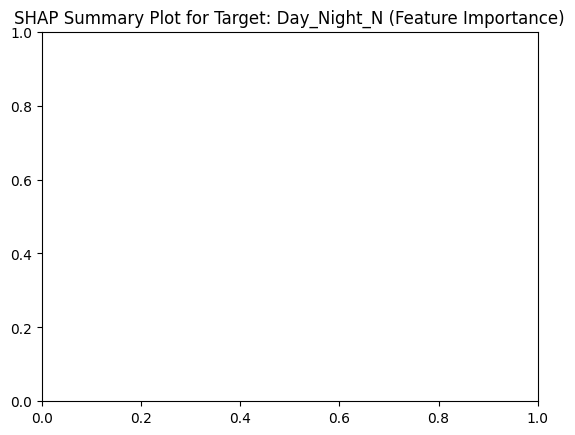

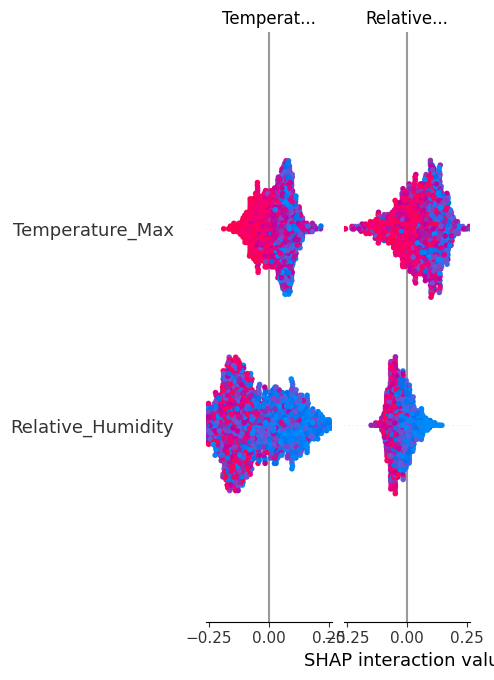

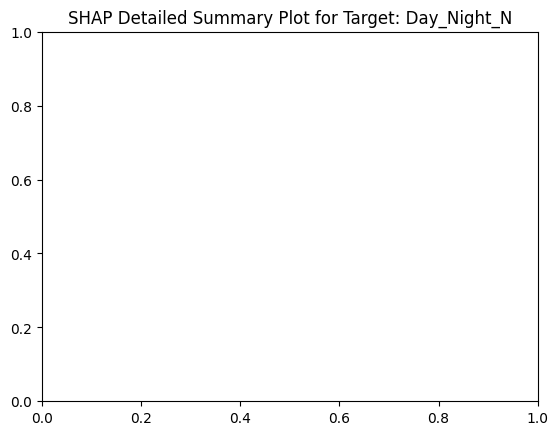

In [ ]:
import shap

# Analyzing Feature Importance with SHAP for Classification
print("Analyzing Feature Importance with SHAP for Classification...")

# Iterate over each target in MultiOutputClassifier
for target_idx, target_name in enumerate(y_train_cat.columns):
    print(f"\nSHAP Analysis for Target: {target_name}")

    # Get the specific classifier for the target
    target_classifier = multioutput_classifier.estimators_[target_idx]

    # Create SHAP explainer for the target classifier
    explainer = shap.TreeExplainer(target_classifier)

    # Compute SHAP values for the target
    shap_values = explainer.shap_values(X_test)

    # Ensure SHAP values match the data shape
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Use the SHAP values for the positive class (1)

    # SHAP summary plot (bar type)
    shap.summary_plot(shap_values, X_test, plot_type="bar")
    plt.title(f"SHAP Summary Plot for Target: {target_name} (Feature Importance)")
    plt.show()

    # SHAP detailed summary plot
    shap.summary_plot(shap_values, X_test)
    plt.title(f"SHAP Detailed Summary Plot for Target: {target_name}")
    plt.show()


Yearly, Monthly, and Seasonal trends of Wildfires in CA

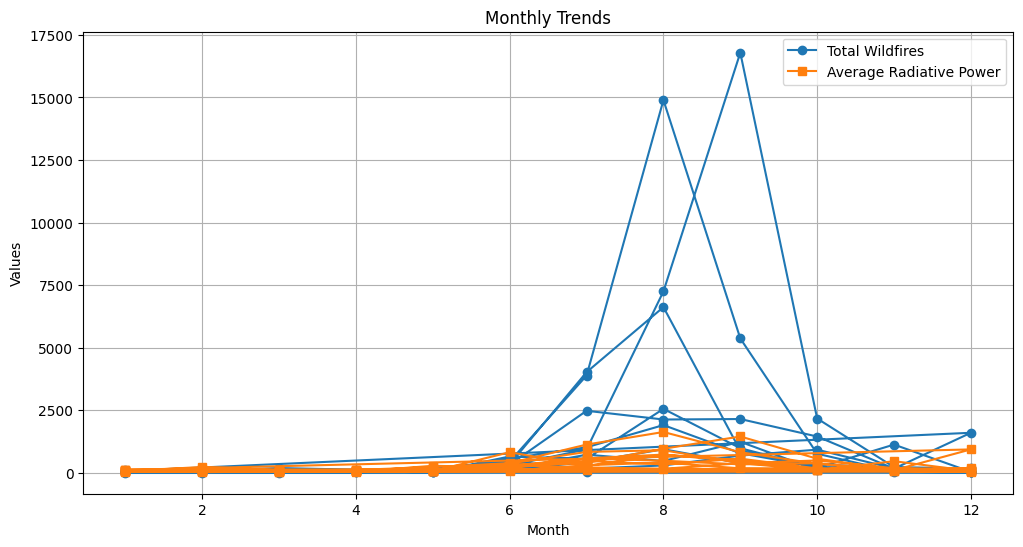

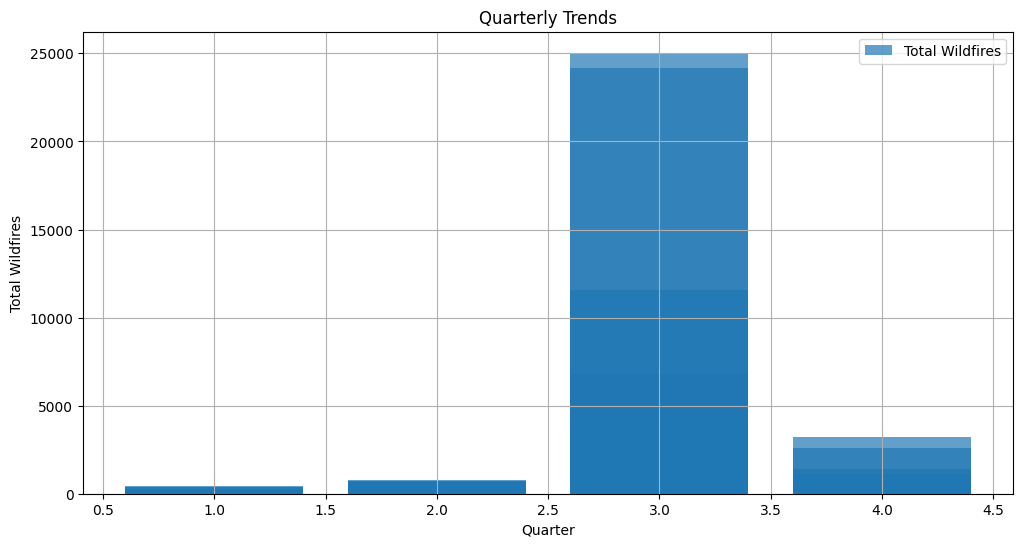

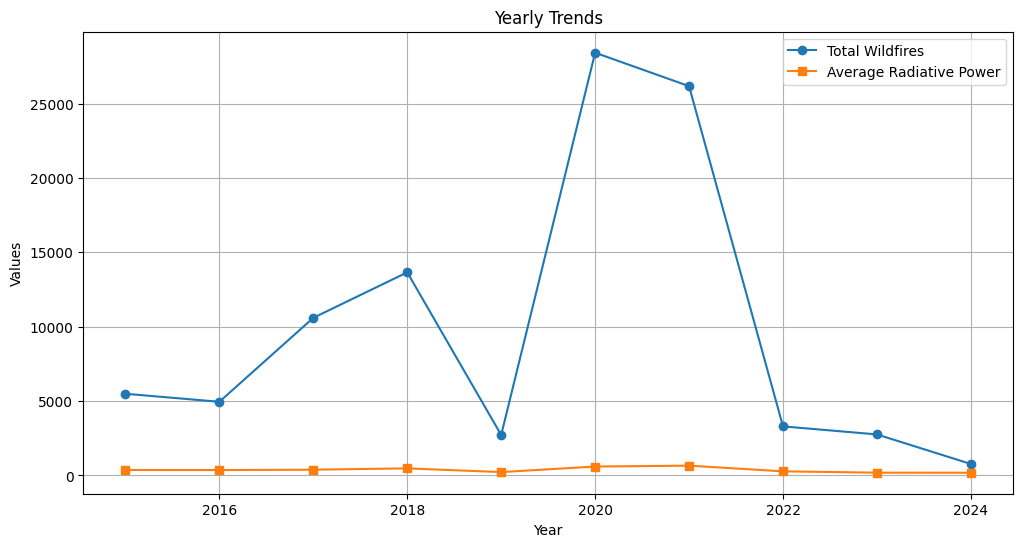

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'merged_fire_climate_dataset.csv'  # Update the path if necessary
dataset = pd.read_csv(file_path)

# Convert 'Date' to datetime
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Extract time-related features
dataset['Month'] = dataset['Date'].dt.month
dataset['Quarter'] = dataset['Date'].dt.quarter
dataset['Year'] = dataset['Date'].dt.year

# Filter for wildfire records
fire_data = dataset[dataset['Fire_Recorded'] == 1]

# Grouping and aggregating
monthly_trends = fire_data.groupby(['Year', 'Month']).agg(
    wildfire_days=('Fire_Recorded', 'sum'),
    total_wildfires=('Total_Fire_Incidents', 'sum'),
    avg_radiative_power=('FRP', 'mean'),
    median_radiative_power=('FRP', 'median')
).reset_index()

quarterly_trends = fire_data.groupby(['Year', 'Quarter']).agg(
    wildfire_days=('Fire_Recorded', 'sum'),
    total_wildfires=('Total_Fire_Incidents', 'sum'),
    avg_radiative_power=('FRP', 'mean'),
    median_radiative_power=('FRP', 'median')
).reset_index()

yearly_trends = fire_data.groupby('Year').agg(
    wildfire_days=('Fire_Recorded', 'sum'),
    total_wildfires=('Total_Fire_Incidents', 'sum'),
    avg_radiative_power=('FRP', 'mean'),
    median_radiative_power=('FRP', 'median')
).reset_index()

# Plotting monthly trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_trends['Month'], monthly_trends['total_wildfires'], label='Total Wildfires', marker='o')
plt.plot(monthly_trends['Month'], monthly_trends['avg_radiative_power'], label='Average Radiative Power', marker='s')
plt.xlabel('Month')
plt.ylabel('Values')
plt.title('Monthly Trends')
plt.legend()
plt.grid()
plt.show()

# Plotting quarterly trends
plt.figure(figsize=(12, 6))
plt.bar(quarterly_trends['Quarter'], quarterly_trends['total_wildfires'], label='Total Wildfires', alpha=0.7)
plt.xlabel('Quarter')
plt.ylabel('Total Wildfires')
plt.title('Quarterly Trends')
plt.legend()
plt.grid()
plt.show()

# Plotting yearly trends
plt.figure(figsize=(12, 6))
plt.plot(yearly_trends['Year'], yearly_trends['total_wildfires'], label='Total Wildfires', marker='o')
plt.plot(yearly_trends['Year'], yearly_trends['avg_radiative_power'], label='Average Radiative Power', marker='s')
plt.xlabel('Year')
plt.ylabel('Values')
plt.title('Yearly Trends')
plt.legend()
plt.grid()
plt.show()

# Saving trends to CSV
monthly_trends.to_csv('monthly_trends.csv', index=False)
quarterly_trends.to_csv('quarterly_trends.csv', index=False)
yearly_trends.to_csv('yearly_trends.csv', index=False)
